## Pressure and Wind


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
from datetime import datetime

# pip
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import circmean

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database

from teslakit.io.matlab import ReadMatfile
from teslakit.util.time_operations import DateConverter_Mat2Py
from windrose import WindroseAxes


C:\Users\lcag075\AppData\Local\Continuum\anaconda2\envs\teslakit\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'C:\Users\lcag075\Dropbox\MAJURO-teslakit\teslakit\DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO')
KMA = db.Load_ESTELA_KMA()  # ESTELA predictor KMA

## WIND

In [3]:
w= xr.open_dataset(os.path.join(p_data, 'sites' ,'MAJURO', 'WIND_PRESSURE','winds_ERA5.nc'))
w=w.sel(latitude=7.25,longitude=171.25).resample(time='1D').mean()
w

dirs=np.arctan2(np.deg2rad(w.u10.values),np.deg2rad(w.v10.values)) * 180 / np.pi-180
dirs[np.where(dirs<0)[0]]=dirs[np.where(dirs<0)[0]]+360
speed=np.sqrt(w.u10.values**2+w.v10.values**2)

wind = xr.Dataset(
        {   'U':(('time'),w.u10.values),
            'V':(('time'),w.v10.values),
            'Dir':(('time'),dirs),
            'Speed':(('time'),speed),
         },coords = {'time': w.time})
wind['time']=wind['time'].dt.round('H').values
wind=wind.resample(time='1D').mean()
wind=wind.sel(time=slice(KMA.time[0],KMA.time[-1]))
print(wind)
wind.to_netcdf(op.join(p_data, 'sites' ,'MAJURO', 'WIND_PRESSURE','Winds.nc'))

<xarray.Dataset>
Dimensions:    (time: 14211)
Coordinates:
  * time       (time) datetime64[ns] 1980-02-04 1980-02-05 ... 2018-12-31
    longitude  float32 171.25
    latitude   float32 7.25
Data variables:
    U          (time) float32 -9.25411 -7.8962555 ... -8.769361 -8.021418
    V          (time) float32 -5.1536503 -4.9040575 ... -5.9111657 -6.736303
    Dir        (time) float32 60.886383 58.157196 ... 56.017273 49.976807
    Speed      (time) float32 10.592387 9.295194 ... 10.575612 10.474775


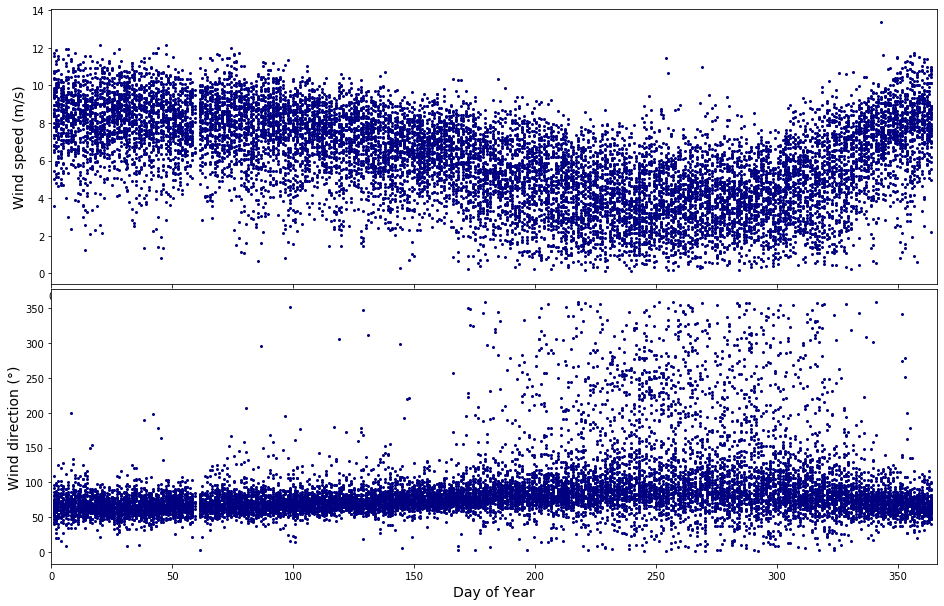

In [4]:
fig = plt.figure(figsize=[15,10])
gs1=gridspec.GridSpec(2,1)
ax1=fig.add_subplot(gs1[0])
ax=fig.add_subplot(gs1[1],sharex=ax1)
 
ax.plot((wind.time.dt.month-1)*30.25+wind.time.dt.day,wind.Dir,'.',markersize=4,color='navy')
ax1.plot((wind.time.dt.month-1)*30.25+wind.time.dt.day,wind.Speed,'.',markersize=4,color='navy')

ax.set_xlim(0,366)
# ax.set_xticks([])
ax.set_ylabel('Wind direction (°)',fontsize=14)
ax1.set_ylabel('Wind speed (m/s)',fontsize=14)
ax.set_xlabel('Day of Year',fontsize=14)
plt.subplots_adjust(left=0.08, bottom=0.11, right=0.9, top=0.88, wspace=0, hspace=0.02) # plt.subplot_tool()


<Figure size 576x576 with 0 Axes>

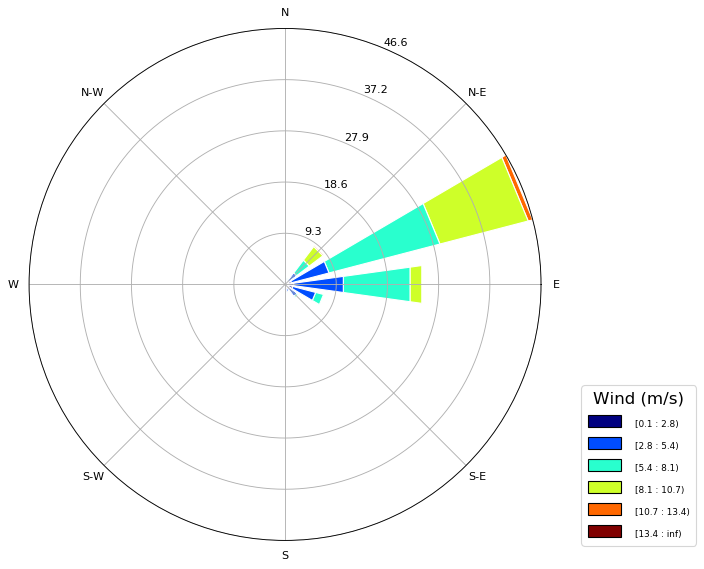

In [5]:
plt.figure(figsize=[8,8]) 
ax = WindroseAxes.from_ax()
ax.bar(wind.Dir, wind.Speed, bins=6, normed=True, opening=0.7, edgecolor='white')
legend=ax.set_legend(fontsize=15,title='Wind (m/s)', title_fontsize=16,loc='best', bbox_to_anchor=(0.65, 0., 0.65, 0.3))
legend.get_title().set_fontsize('15') 
plt.rc('legend',**{'fontsize':15})

## PRESSURE

In [6]:
p= xr.open_dataset(os.path.join(p_data, 'sites' ,'MAJURO', 'WIND_PRESSURE','pressures_ERA5.nc'))
p=p.sel(latitude=7.25,longitude=171.25).resample(time='1D').mean()
p=p.sel(time=slice(KMA.time[0],KMA.time[-1]))
print(p)
p.to_netcdf(op.join(p_data, 'sites' ,'MAJURO', 'WIND_PRESSURE','Pressures.nc'))

<xarray.Dataset>
Dimensions:    (time: 14211)
Coordinates:
  * time       (time) datetime64[ns] 1980-02-04 1980-02-05 ... 2018-12-31
    longitude  float32 171.25
    latitude   float32 7.25
Data variables:
    msl        (time) float32 100771.88 100827.06 ... 100688.58 100683.555


Text(0.5, 0, 'Day of Year')

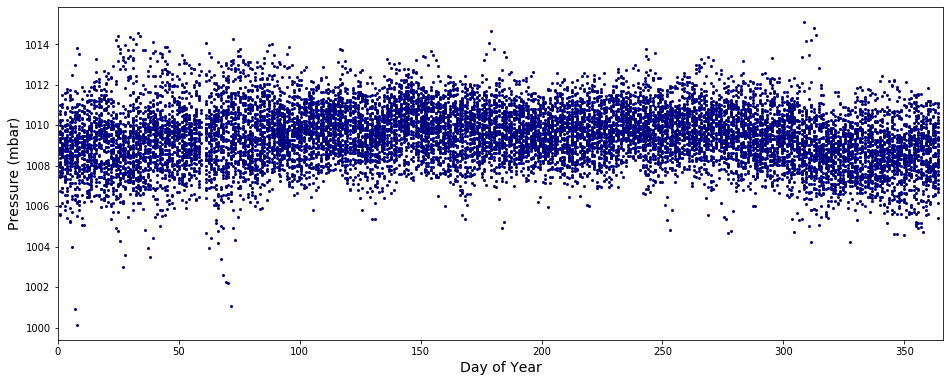

In [7]:
fig = plt.figure(figsize=[15,6])
gs1=gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs1[0])

 
ax.plot((p.time.dt.month-1)*30.25+p.time.dt.day,p.msl/100,'.',markersize=4,color='navy')

ax.set_xlim(0,366)
# ax.set_xticks([])
ax.set_ylabel('Pressure (mbar)',fontsize=14)
plt.subplots_adjust(left=0.08, bottom=0.11, right=0.9, top=0.88, wspace=0, hspace=0.02) # plt.subplot_tool()
ax.set_xlabel('Day of Year',fontsize=14)


In [8]:
mean_w=np.full([len(np.unique(KMA.sorted_bmus))],np.nan)
mean_w_dir=np.full([len(np.unique(KMA.sorted_bmus))],np.nan)
mean_p=np.full([len(np.unique(KMA.sorted_bmus))],np.nan)

for a in range(len(np.unique(KMA.sorted_bmus))):
    
    mean_w[a]=np.nanmean(wind.Speed.values[np.where(KMA.sorted_bmus==a)[0]])
    mean_w_dir[a]=np.nanmean(wind.Dir[np.where(KMA.sorted_bmus==a)[0]])
    mean_p[a]=np.nanmean(p.msl[np.where(KMA.sorted_bmus==a)[0]])
    

In [9]:
def Plot_Var_DWT(KMA,var,lim,label):
#     order=[0,6,12,18,24,30,1,7,13,19,25,31,2,8,14,20,26,32,3,9,15,21,27,33,4,10,16,22,28,34,5,11,17,23,29,35]
    fig = plt.figure(figsize=[15,15])
    gs1=gridspec.GridSpec(6,6)
    for a in range(len(np.unique(KMA.sorted_bmus))):
        ax=fig.add_subplot(gs1[a])
        ax.set_xlim(np.nanmin(var),np.nanmax(var))
        ax.set_ylim(0,lim)
        ax.grid(True,color='grey',linestyle=':',alpha=0.7)
        ax.text(np.nanmin(var)+(np.nanmax(var)-np.nanmin(var))/9,0.85*lim,'DWT'+str(a+1),fontsize=11,fontweight='bold')
        if a>=30:
            ax.set_xlabel(label,fontsize=12)
            ax.xaxis.set_tick_params(labelsize=12)
        else:
            ax.set_xticklabels([])
        if (a==0) | (a==6) | (a==12) | (a==18) | (a==24) | (a==30):
            ax.set_ylabel('Probability',fontsize=12)
            ax.yaxis.set_tick_params(labelsize=12)
        else:
            ax.set_yticklabels([])
        ax.hist(var[np.where(KMA.sorted_bmus==a)[0]],density=True, bins=np.linspace(np.nanmin(var),np.nanmax(var),20), alpha=0.5, color='slateblue', ec='darkmagenta')


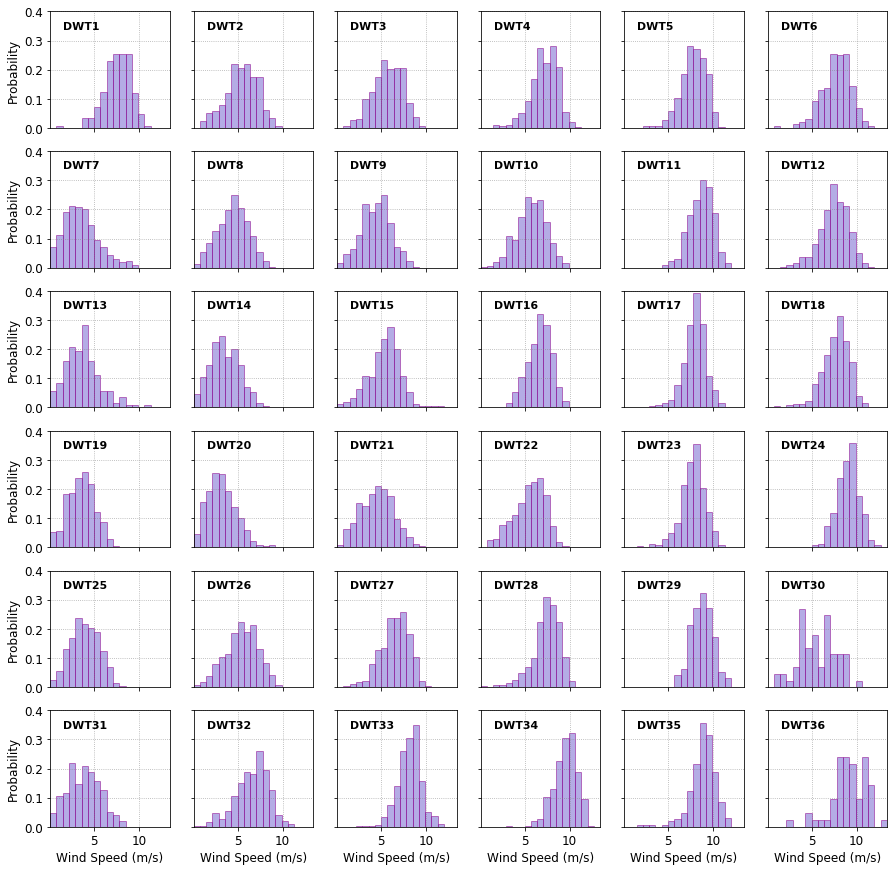

In [10]:
Plot_Var_DWT(KMA,wind.Speed,0.4,'Wind Speed (m/s)')

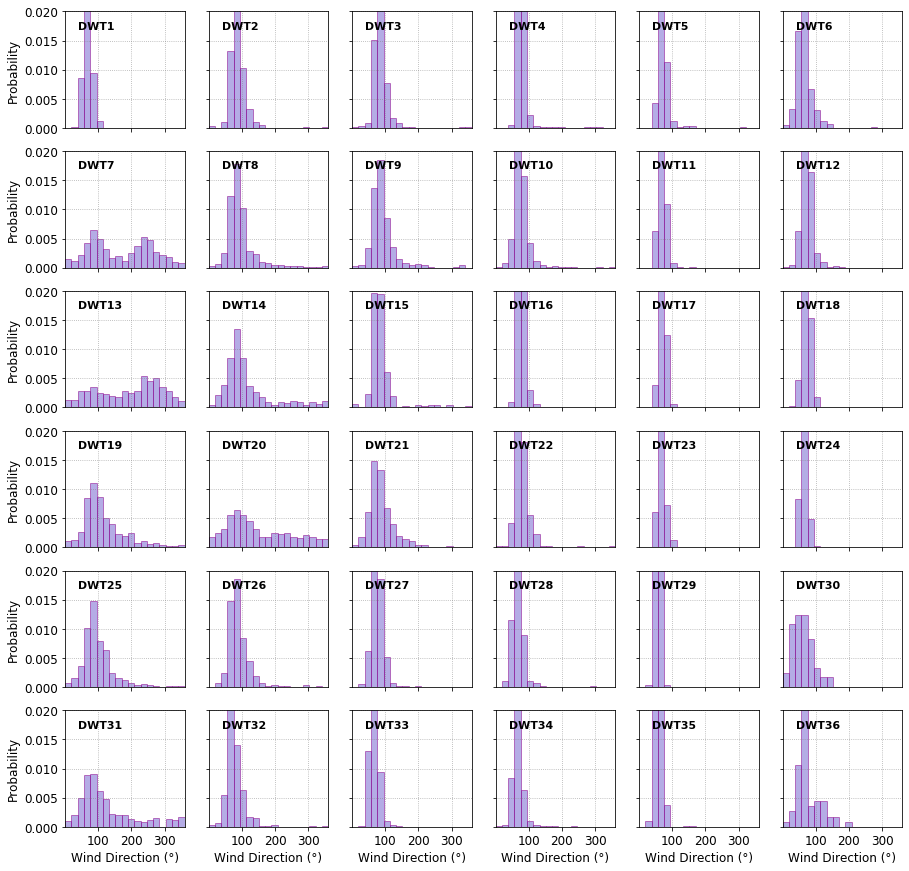

In [11]:
Plot_Var_DWT(KMA,wind.Dir,0.02,'Wind Direction (°)')

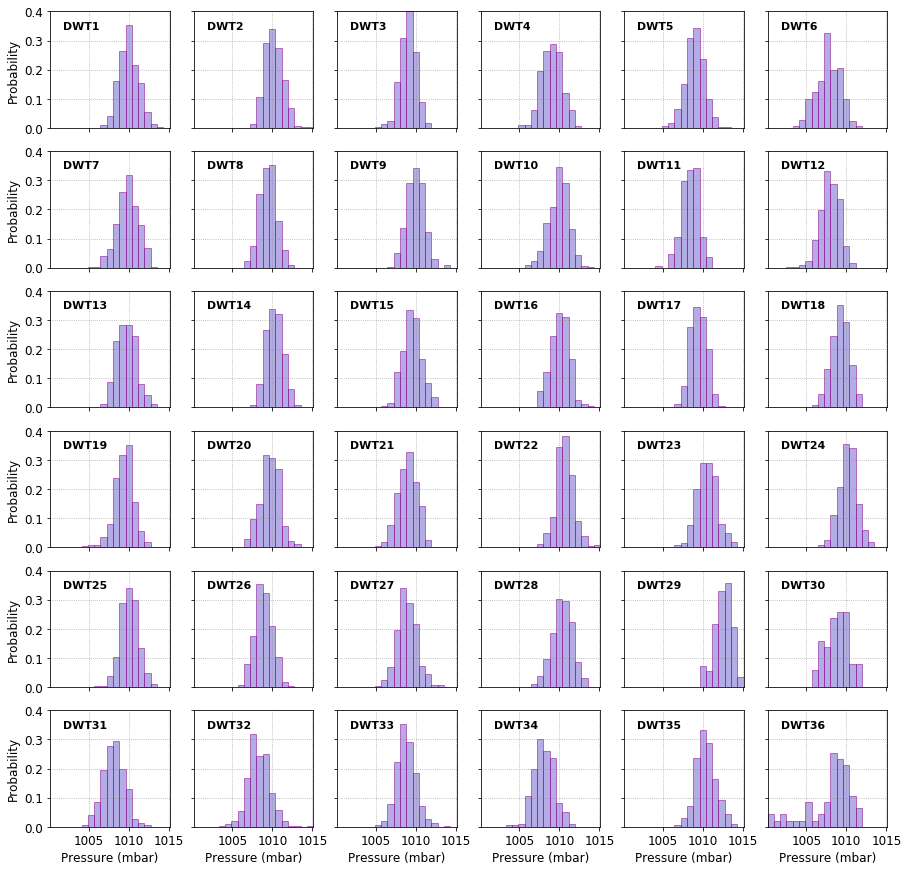

In [12]:
Plot_Var_DWT(KMA,p.msl/100,0.4,'Pressure (mbar)')

## SEICHE - WIND

In [13]:
data_path=r'C:\Users\lcag075\Dropbox\MAJURO-teslakit\teslakit\DATA\sites\MAJURO'
data=xr.open_dataset(os.path.join(data_path,'Seiche','hm0_daily_360secfrequency.nc'))
data['time']=data.time.dt.floor('d')

kma = xr.open_dataset(os.path.join(r'C:\Users\lcag075\Dropbox\Culebras-uoa\MAJURO\DATA\DWTs', "kma.nc"))
kma = xr.Dataset(
        {   'bmus':(('time'),kma.sorted_bmus.values),
         },coords = {'time': kma.time.values})

ini=max(kma.time[0],data.time[0]).values
fin=min(kma.time[-1],data.time[-1]).values
print('Time beginning: ' + str(ini))
print('Time end: ' + str(fin))
kma=kma.sel(time = slice(ini,fin))
data=data.sel(time = slice(ini,fin))
data['bmus']=kma.bmus

hm0corr=data.hm0.values-0.01; 
hm0corr[np.where(hm0corr<0)]=np.nan

data['hm0']=(['time'], hm0corr)

print(data)

Time beginning: 1993-05-01T00:00:00.000000000
Time end: 2018-12-31T00:00:00.000000000
<xarray.Dataset>
Dimensions:  (time: 9376)
Coordinates:
  * time     (time) datetime64[ns] 1993-05-01 1993-05-02 ... 2018-12-31
Data variables:
    hm0      (time) float64 nan nan nan nan nan ... 0.003386 0.0103 nan 0.003743
    bmus     (time) int64 16 23 23 23 22 22 22 22 22 ... 10 17 17 11 33 33 33 5


In [14]:
wind

<xarray.Dataset>
Dimensions:    (time: 14211)
Coordinates:
  * time       (time) datetime64[ns] 1980-02-04 1980-02-05 ... 2018-12-31
    longitude  float32 171.25
    latitude   float32 7.25
Data variables:
    U          (time) float32 -9.25411 -7.8962555 ... -8.769361 -8.021418
    V          (time) float32 -5.1536503 -4.9040575 ... -5.9111657 -6.736303
    Dir        (time) float32 60.886383 58.157196 ... 56.017273 49.976807
    Speed      (time) float32 10.592387 9.295194 ... 10.575612 10.474775

In [15]:
ini=max(wind.time[0],data.time[0]).values
fin=min(wind.time[-1],data.time[-1]).values
wind=wind.sel(time=slice(ini,fin))
data=data.sel(time=slice(ini,fin))

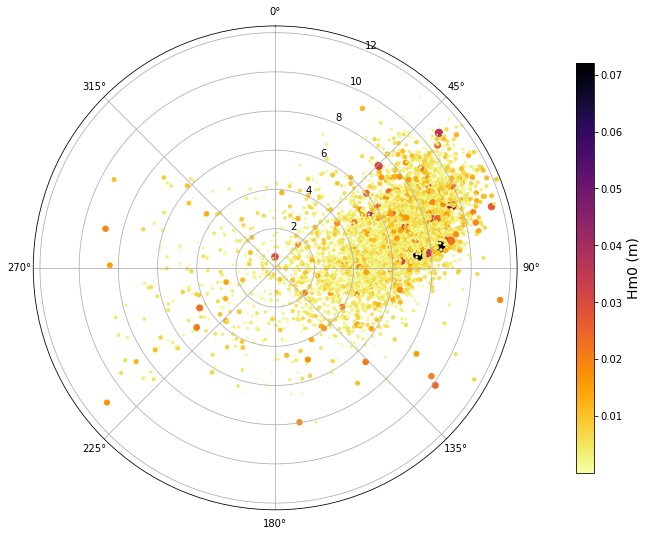

In [18]:
fig = plt.figure(figsize=[10,10])
gs1=gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs1[0], projection='polar')
ax.set_theta_zero_location('N', offset=0)
ax.set_theta_direction(-1)

p1=ax.scatter(np.deg2rad(wind.Dir),wind.Speed,(data.hm0)*1500,(data.hm0),cmap='inferno_r')
# cbar = plt.colorbar(p1, ax=ax, pad=0.15, format='%.2f')
# cbar.set_label('Hm0 (m)') 

gs1.tight_layout(fig, rect=[0.05, [], 0.80, []])


gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0])
plt.colorbar(p1,cax=ax1)
ax1.set_ylabel('Hm0 (m)',fontsize=14)
gs2.tight_layout(fig, rect=[0.83, 0.2, 0.95, 0.8])


Text(0.5, 0, '$\\Delta$ Wind (m/s)')

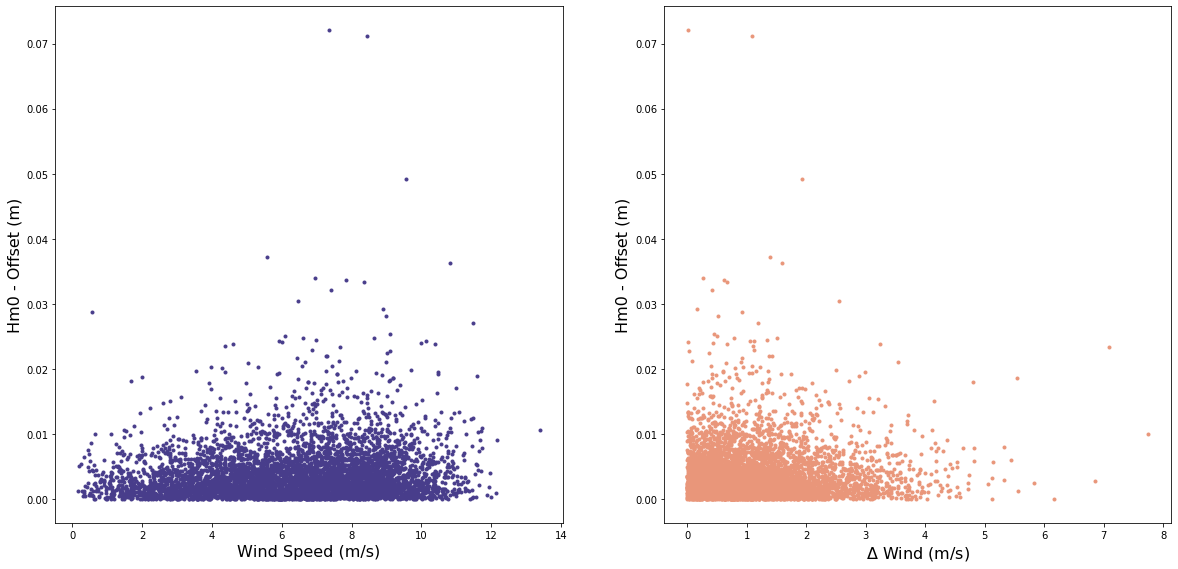

In [56]:
delta1=np.abs(np.diff(wind.Speed))
hm0=data.hm0[1:]

fig = plt.figure(figsize=[20,9.5])
gs2=gridspec.GridSpec(1,2)
ax2=fig.add_subplot(gs2[0])
ax2.plot(wind.Speed,data.hm0,'.',color='darkslateblue')
ax2.set_ylabel('Hm0 - Offset (m)',fontsize=16)
ax2.set_xlabel('Wind Speed (m/s)',fontsize=16)

ax2=fig.add_subplot(gs2[1])
ax2.plot(delta1,hm0,'.',color='darksalmon')
ax2.set_ylabel('Hm0 - Offset (m)',fontsize=16)
ax2.set_xlabel('$\Delta$ Wind (m/s)',fontsize=16)